In [2]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

from seaborn import color_palette
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier


import sklearn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [3]:
circuits_df = pd.read_csv('datasets/circuits.csv')
races_df = pd.read_csv('datasets/races.csv')
driver_standings_df = pd.read_csv('datasets/driver_standings.csv')
constructor_standings_df = pd.read_csv('datasets/constructor_standings.csv')
drivers_df = pd.read_csv('datasets/drivers.csv')
constructors_df = pd.read_csv("datasets/constructors.csv")
results_df = pd.read_csv("datasets/results.csv")
status_df = pd.read_csv("datasets/status.csv")
pitstops_df = pd.read_csv("datasets/pit_stops.csv")

In [4]:
constructors_df = constructors_df.rename({'name' : 'Team'}, axis=1)
pitstops_df = pitstops_df.drop(['duration'], axis=1)
newResults_df = pd.merge(results_df, drivers_df[['driverId','nationality','dob']], on= 'driverId',how='left')
newResults_df = pd.merge(newResults_df, races_df[['raceId', 'year', 'circuitId', 'date']], on='raceId', how='left')
newResults_df = pd.merge(newResults_df, constructors_df[['constructorId','Team']], on='constructorId', how='left')
newResults_df['statusId'] = newResults_df['statusId'].replace([11,12,13,14,15,16,17,18,19,45,50,128,53,55,58,88,111,112,113,114,115,116,117,118,119,120,122,123,124,125,127,133,134], 1)
newResults_df = pd.merge(newResults_df, status_df[['status', 'statusId']], on='statusId', how='left')
newResults_df['date'] = pd.to_datetime(newResults_df['date'])
newResults_df['dob'] = pd.to_datetime(newResults_df['dob'])
newResults_df['age'] = ((newResults_df['date'] - newResults_df['dob']).dt.days/365.25).astype(int)
driverxp_df = newResults_df.sort_values(by=['driverId','date'])
driverxp_df['totalracexp'] = driverxp_df.groupby('driverId').cumcount()
newResults_df = pd.merge(newResults_df, driverxp_df[['resultId','totalracexp']], on='resultId', how='left')
newResults_df = newResults_df.rename({'positionOrder':'finish', 'grid':'start'}, axis=1)
newResults_df = newResults_df.replace('\\N', np.nan)
newResults_df = newResults_df.fillna(0)
newResults_df[['milliseconds','fastestLap']] = newResults_df[['milliseconds','fastestLap']].astype(int)
newResults_df['PositionsGain'] = newResults_df['start'] - newResults_df['finish']

pitstops_df['milliseconds'] = pitstops_df['milliseconds'] / 1000.0
pitstops_df = pitstops_df.rename({'milliseconds':'duration'}, axis=1)

newResults_df = newResults_df.drop(
    ['rank', 'positionText','position','number',
     'time', 'laps', 'resultId', 'fastestLap',
     'dob', 'date', 'fastestLapSpeed',
     'nationality','time',
     'statusId','Team','status','fastestLapTime'], axis=1)

merged_pitstops_df = pd.merge(pitstops_df, newResults_df, on=['driverId', 'raceId'], how='left')
merged_pitstops_df = merged_pitstops_df[merged_pitstops_df['start'] != 0] # remove broken data
merged_pitstops_df = merged_pitstops_df[merged_pitstops_df['stop'] < 8] # remove broken data
merged_pitstops_df = merged_pitstops_df[merged_pitstops_df['duration'] < 200.0] # removes red flag cases/outliers
merged_pitstops_df['pit_impact'] = np.where(merged_pitstops_df['finish'] < merged_pitstops_df['start'], 1, 0)
merged_pitstops_df['pit_efficiency'] = (merged_pitstops_df['PositionsGain'] / merged_pitstops_df['stop']) / merged_pitstops_df['duration']
merged_pitstops_df = merged_pitstops_df.drop(['time'], axis=1)


### Data Preprocessing and Visualization

In [5]:
merged_pitstops_df

,raceId,driverId,stop,lap,duration,constructorId,start,finish,points,milliseconds,year,circuitId,age,totalracexp,PositionsGain,pit_impact,pit_efficiency
0,841,153,1,1,26.898,5,12,11,0.0,0,2011,1,21,27,1,1,0.037177
1,841,30,1,1,25.021,131,11,19,0.0,0,2011,1,42,269,-8,0,-0.319731
2,841,17,1,11,23.426,9,3,5,10.0,5408430,2011,1,34,159,-2,0,-0.085375
3,841,4,1,12,23.251,6,5,4,12.0,5402031,2011,1,29,159,1,1,0.043009
4,841,13,1,13,23.842,6,8,7,6.0,5455445,2011,1,29,135,1,1,0.041943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10984,1132,832,2,39,29.097,6,7,5,11.0,4994377,2024,9,29,195,2,1,0.034368
10985,1132,807,2,39,30.265,210,6,6,8.0,5002781,2024,9,36,217,0,0,0.000000
10986,1132,840,2,39,29.469,117,8,7,6.0,5003628,2024,9,25,155,1,1,0.016967
10987,1132,839,4,38,29.086,214,18,16,0.0,0,2024,9,27,144,2,1,0.017190


In [6]:
newResults_df

,raceId,driverId,constructorId,start,finish,points,milliseconds,year,circuitId,age,totalracexp,PositionsGain
0,18,1,1,1,1,10.0,5690616,2008,1,23,17,0
1,18,2,2,5,2,8.0,5696094,2008,1,30,133,3
2,18,3,3,7,3,6.0,5698779,2008,1,22,35,4
3,18,4,4,11,4,5.0,5707797,2008,1,26,105,7
4,18,5,1,3,5,4.0,5708630,2008,1,26,17,-2
...,...,...,...,...,...,...,...,...,...,...,...,...
26514,1132,839,214,18,16,0.0,0,2024,9,27,144,2
26515,1132,815,9,0,17,0.0,0,2024,9,34,270,-17
26516,1132,855,15,14,18,0.0,0,2024,9,25,55,-4
26517,1132,847,131,1,19,0.0,0,2024,9,26,115,-18


<Figure size 400x200 with 0 Axes>

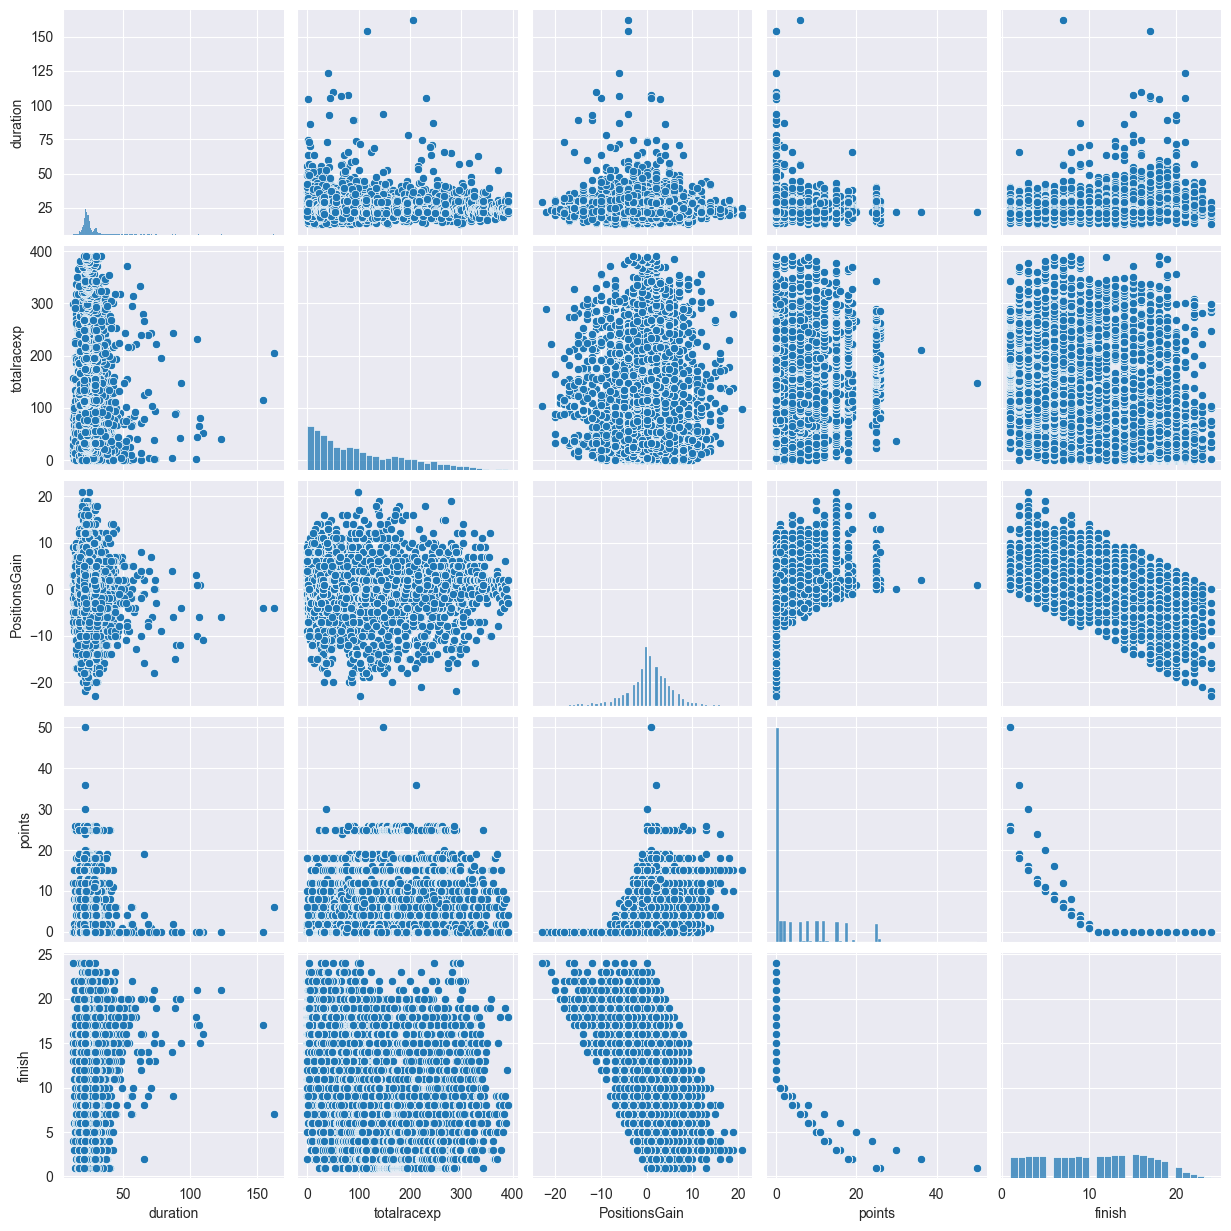

In [7]:
plt.figure(figsize=(4,2))
sns.pairplot(merged_pitstops_df[['duration','totalracexp','PositionsGain','points','finish']])

<Axes: xlabel='duration', ylabel='PositionsGain'>

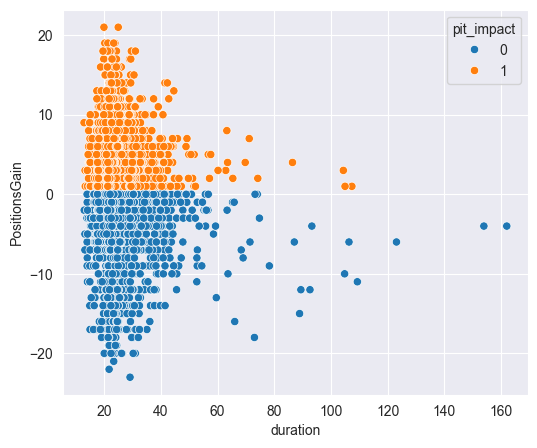

In [8]:
plt.figure(figsize=(6,5))
sns.scatterplot(x='duration', y='PositionsGain', data=merged_pitstops_df, hue='pit_impact')

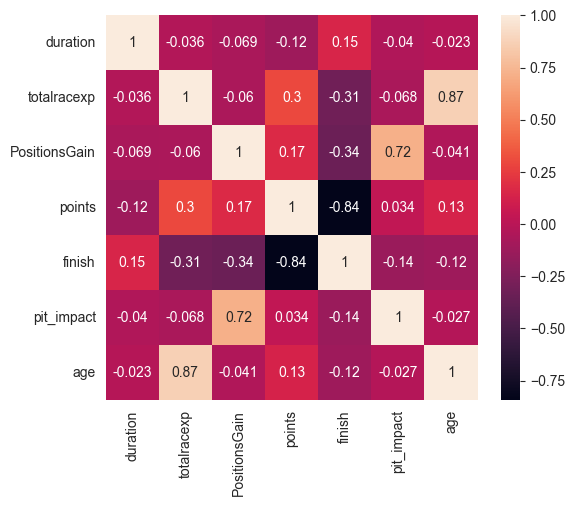

In [9]:
corr_m = merged_pitstops_df[['duration','totalracexp','PositionsGain','points','finish', 'pit_impact', 'age']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_m, annot=True)
plt.show()

### Data Preprocessing

In [10]:
def get_train_valid_test_data(
        X: np.ndarray,
        y: np.ndarray,
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [11]:
def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    """ Gets preprocessed data for training, validation, and testing

        Return:
            A tuple of NumPy arrays where indices 0-1
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= get_train_valid_test_data(merged_pitstops_df.drop(['pit_efficiency'], axis=1).values, merged_pitstops_df['pit_efficiency'].values)

    scaler = StandardScaler()

    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

### Random Forest Model

### Neural Network model

In [12]:
class Linear():
    """ The linear or identity actionvation function """
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the linear activation function """
        return z

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative for the linear activation function """
        return np.ones(z.shape)

In [13]:
class Tanh():
    """ The tanh actionvation function """
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the tanh activation function """
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative of the tanh activation function """
        return 1 - np.tanh(z)**2

In [14]:
def init_weights(
        n_input_features: int,
        hidden_neurons: int,
        output_neurons: int,
) -> Tuple[np.ndarray, ...]:

    W1, b1, W2, b2 = None, None, None, None

    W1 = np.random.uniform(low=-0.5, high=0.5, size=(n_input_features, hidden_neurons))
    b1 = np.ones([1, hidden_neurons])

    W2 = np.random.uniform(low=-0.5, high=0.5, size=(hidden_neurons, output_neurons))
    b2 = np.ones([1, output_neurons])

    return W1, b1, W2, b2

In [15]:
def forward(
        X: np.ndarray,
        W1: np.ndarray,
        b1: np.ndarray,
        W2: np.ndarray,
        b2: np.ndarray,
) -> Tuple[np.ndarray, ...]:

    Z1, A1, Z2, A2 = None, None, None, None
    Z1 = X @ W1 + b1
    A1 = Tanh.activation(Z1)
    Z2 = A1 @ W2 + b2
    A2 = Linear.activation(Z2)
    return Z1, A1, Z2, A2

In [16]:
def output_layer_grads(
        X: np.ndarray,
        y: np.ndarray,
        W1: np.ndarray,
        Z1: np.ndarray,
        A1: np.ndarray,
        W2: np.ndarray,
        Z2: np.ndarray,
        A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:

    delta_mse_A2 = A2 - y
    delta_A2_Z2 = Linear.derivative(Z2)
    delta_Z2_W2 = A1
    delta_Z2_b2 = np.ones([len(y), 1])
    delta_mse_Z2 = delta_mse_A2 * delta_A2_Z2
    delta_mse_W2 = delta_Z2_W2.T  @ delta_mse_Z2
    delta_mse_b2 = delta_Z2_b2.T @  delta_mse_Z2

    W2_avg_grad, b2_avg_grad = delta_mse_W2 / len(y), delta_mse_b2 / len(y)

    return W2_avg_grad, b2_avg_grad

In [17]:
def hidden_layer_grads(
        X: np.ndarray,
        y: np.ndarray,
        W1: np.ndarray,
        Z1: np.ndarray,
        A1: np.ndarray,
        W2: np.ndarray,
        Z2: np.ndarray,
        A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:

    delta_mse_A2 = A2 - y
    delta_A2_Z2 = Linear.derivative(Z2)
    delta_Z2_A1 = W2
    delta_A1_Z1 = Tanh.derivative(Z1)
    delta_Z1_W1 = X
    delta_Z1_b1 = np.ones([len(y), 1])
    delta_mse_A1 = (delta_mse_A2 * delta_A2_Z2) @ delta_Z2_A1.T

    delta_mse_b1 = delta_Z1_b1.T @ (delta_mse_A1 * delta_A1_Z1)

    delta_mse_W1 = delta_Z1_W1.T @ (delta_mse_A1 * delta_A1_Z1)

    W1_avg_grad, b1_avg_grad = delta_mse_W1 / len(y), delta_mse_b1 / len(y)

    return W1_avg_grad, b1_avg_grad

In [18]:
def get_batches(
        data_len: int,
        batch_size: int = 32,
) -> List[np.ndarray]:

    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [19]:
class NeuralNetwork():
    def __init__(self,
                 hidden_neurons: int,
                 output_neurons: int,
                 alpha: float,
                 batch_size: int,
                 epochs: int = 1,
                 seed: int = 0,
                 ):

        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed

        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        self.trn_error = None
        self.vld_error = None

    def fit(
            self,
            X: np.ndarray,
            y: np.ndarray,
            X_vld: np.ndarray = None,
            y_vld:np.ndarray = None,
    ):

        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []

        self.W1, self.b1, self.W2, self.b2 = init_weights(X.shape[1], self.hidden_neurons, self.output_neurons)

        for e in range (self.epochs):
            batches = get_batches(len(y), self.batch_size)

            for b in batches:
                Z1, A1, Z2, A2 = forward(X[b], self.W1, self.b1, self.W2, self.b2)
                W2avgG, b2avgG = output_layer_grads(X[b], y[b], self.W1, Z1, A1, self.W2, Z2, A2)
                W1avgG, b1avgG = hidden_layer_grads(X[b], y[b], self.W1, Z1, A1, self.W2, Z2, A2)

                self.W2 = self.W2 - (self.alpha * W2avgG)
                self.b2 = self.b2 - (self.alpha * b2avgG)
                self.W1 = self.W1 - (self.alpha * W1avgG)
                self.b1 = self.b1 - (self.alpha * b1avgG)

            y_hat = self.predict(X)
            self.trn_error.append(rmse(y, y_hat))

            # If validation data is provided, calculate validation RMSE
            if X_vld is not None and y_vld is not None:
                y_vld_hat = self.predict(X_vld)
                self.vld_error.append(rmse(y_vld, y_vld_hat))

        return self

    def predict(self, X: np.ndarray):

        Z1, A1, Z2, A2 = forward(X, self.W1, self.b1, self.W2, self.b2)

        return A2

#### Train and Evaluate Neural Network

Train MSE: 0.0010136457301361452
Train RMSE: 0.031837803475367854
Validation MSE: 0.001045368504011647
Validation RMSE: 0.032332158975417136
Test MSE: 0.0011124793000983216
Test RMSE: 0.03335384985422705


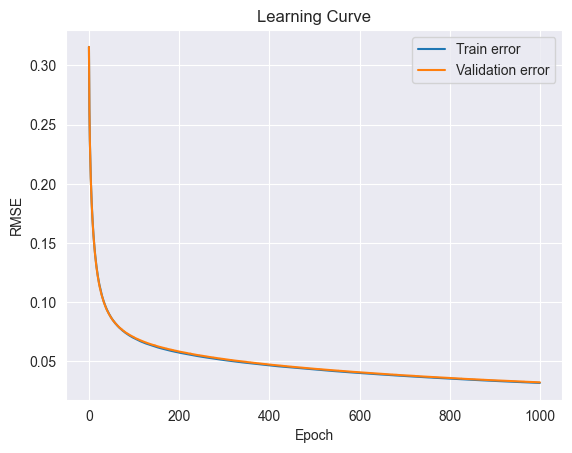

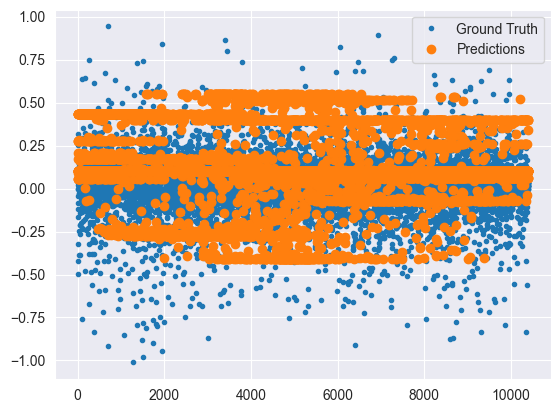

In [20]:
X, y = merged_pitstops_df.drop(['pit_efficiency'], axis=1).values, merged_pitstops_df['pit_efficiency'].values
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

nn = NeuralNetwork(hidden_neurons=20,
                   output_neurons=1,
                   batch_size=64,
                   alpha=0.01,
                   epochs=1000,
                   seed=0)

nn.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)

y_hat_trn = nn.predict(X_trn)

trn_mse_score = mse(y_trn, y_hat_trn)
trn_rmse_score = rmse(y_trn, y_hat_trn)
print(f"Train MSE: {trn_mse_score}")
print(f"Train RMSE: {trn_rmse_score}")

y_hat_vld = nn.predict(X_vld)
vld_mse_score = mse(y_vld, y_hat_vld)
vld_rmse_score = rmse(y_vld, y_hat_vld)
print(f"Validation MSE: {vld_mse_score}")
print(f"Validation RMSE: {vld_rmse_score}")

y_hat_tst = nn.predict(X_tst)
tst_mse_score = mse(y_tst, y_hat_tst)
tst_rmse_score = rmse(y_tst, y_hat_tst)
print(f"Test MSE: {tst_mse_score}")
print(f"Test RMSE: {tst_rmse_score}")

plt.plot(nn.trn_error, label='Train error')
plt.plot(nn.vld_error, label='Validation error')
plt.title("Learning Curve")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(y, '.', label='Ground Truth')
plt.plot(nn.predict(X), 'o', label='Predictions')
plt.legend()
plt.show()